In [ ]:
# !pip install yfinance

In [ ]:
# !pip install arch

In [ ]:
# !pip install pmdarima

In [ ]:
from datetime import datetime, timedelta
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from arch.__future__ import reindexing
import math
import numpy as np
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
BTC = pd.read_csv('MyDrive/dataset/btcprice.csv')

In [ ]:
BTC['Date'] = pd.to_datetime(BTC['Date'])
BTC = BTC.set_index('Date')

In [ ]:
BTC.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-01,430.72,436.25,427.52,434.33,36278900.0
2016-01-02,434.62,436.06,431.87,433.44,30096600.0
2016-01-03,433.58,433.74,424.71,430.01,39633800.0
2016-01-04,430.06,434.52,429.08,433.09,38477500.0
2016-01-05,433.07,434.18,429.68,431.96,34522600.0


In [ ]:
BTC.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-10-26,63032.76,63229.03,59991.16,60363.79,3.487897e+10
2021-10-27,60352.00,61435.18,58208.19,58482.39,4.365708e+10
2021-10-28,58470.73,62128.63,58206.92,60622.14,4.525708e+10
2021-10-29,60624.87,62927.61,60329.97,62227.96,3.685688e+10
2021-10-30,62239.36,62330.15,60918.39,61888.83,3.215794e+10


In [ ]:
BTC.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
BTC.shape

(2130, 5)

Text(0.5, 1.0, 'BTC Closed Price')

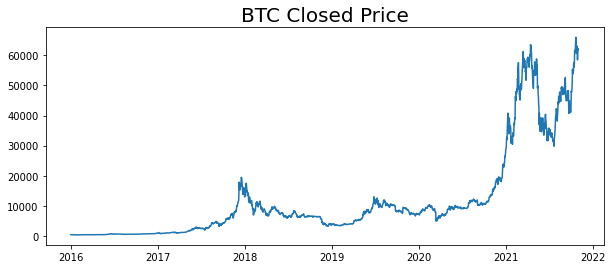

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(BTC['Close'])
# plt.ylabel('Closing Price', fontsize=16)
plt.title('BTC Closed Price', fontsize=20)

In [ ]:
BTC.describe()

,Open,High,Low,Close,Volume
count,2130.000000,2130.000000,2130.000000,2130.000000,2.130000e+03
mean,11759.639901,12094.375545,11404.055925,11788.439408,1.712475e+10
std,14976.382126,15426.740731,14487.609121,15014.021381,2.095281e+10
min,365.070000,374.950000,354.910000,364.330000,2.851400e+07
25%,2492.880000,2562.272500,2378.505000,2493.005000,1.074637e+09
50%,7229.510000,7388.280000,7076.935000,7241.050000,7.920519e+09
75%,10797.552500,11052.652500,10509.222500,10800.497500,2.747029e+10
max,66002.230000,66930.390000,63610.670000,65992.840000,3.510000e+11


In [ ]:
ret = np.log(BTC['Close']/BTC['Close'].shift(1)).dropna()
ret = pd.DataFrame({'returns':ret}) 
ret_pct = ret*100

In [ ]:
ret.head()

,returns
Date,
2016-01-02,-0.002051
2016-01-03,-0.007945
2016-01-04,0.007137
2016-01-05,-0.002613
2016-01-06,-0.006620


Statistics of Return (Skewness & Kurtosis)

In [ ]:
ret.describe()

,returns
count,2129.000000
mean,0.002329
std,0.040154
min,-0.464730
25%,-0.012910
50%,0.002220
75%,0.018729
max,0.225119


In [ ]:
#Skewness and Kurtosis
ret.kurtosis()


ret    11.703498
dtype: float64

In [ ]:
ret.skew()

ret   -0.777529
dtype: float64

Text(0.5, 1.0, 'Bitcoin Returns')

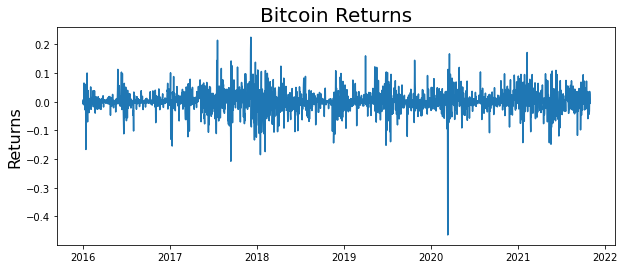

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(ret)
plt.ylabel('Returns', fontsize=16)
plt.title('Bitcoin Returns', fontsize=20)

Text(0.5, 1.0, 'BTC-USD Returns (%)')

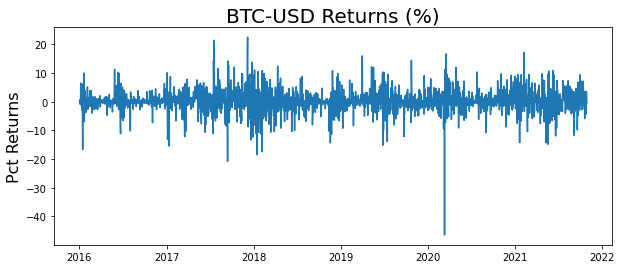

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(ret*100)
plt.ylabel('Pct Returns', fontsize=16)
plt.title('BTC-USD Returns (%)', fontsize=20)

Text(0.5, 1.0, 'BTC-USD Squared-Returns')

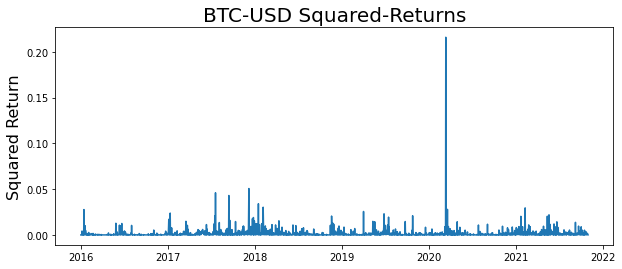

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(ret**2)
plt.ylabel('Squared Return', fontsize=16)
plt.title('BTC-USD Squared-Returns', fontsize=20)

Text(0.5, 1.0, 'BTC-USD Distribution Plot')

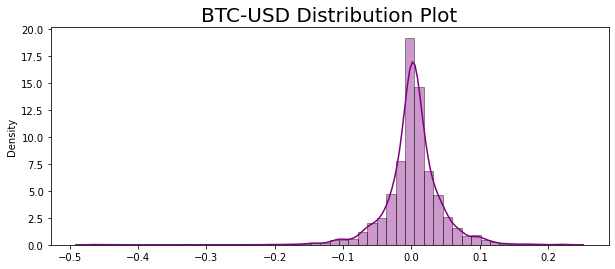

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,4))
sns.distplot(ret, color='purple', hist_kws={"edgecolor": 'black'}, label = 'Return Histogram')
plt.title('BTC-USD Distribution Plot', fontsize=20)

In [ ]:
## Test of Normality
kurt = ret.ret.kurtosis()
skew = ret.ret.skew()
stat = int(jarque_bera(ret)[0])
p = int(jarque_bera(ret)[1])

print(f'-------------------------------\nTest of Normality (Jarque Bera) \n-------------------------------\nStatistic:   {stat} \np-value:     {p} \nSkewness:    {skew} \nKurtosis:    {kurt}')

-------------------------------
Test of Normality (Jarque Bera) 
-------------------------------
Statistic:   12301 
p-value:     0 
Skewness:    -0.777529497718993 
Kurtosis:    11.703498194271997


In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
def perform_ADF(X):
    ADF_test = adfuller(X)
    print('ADF Statistic: %f' % ADF_test[0])
    print('p-value: %f' % ADF_test[1])
    print('Critical Values:')
    for key, value in ADF_test[4].items():
        print('\t%s: %.3f' % (key, value))
    


def perform_kpss(X):
    kpss_test = kpss(X)    
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('lags: %f' % kpss_test[2])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
perform_ADF(ret)

ADF Statistic: -32.081211
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [ ]:
perform_kpss(ret)

KPSS Statistic: 0.103070
p-value: 0.100000
lags: 7.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


The Unit Root Test ABOVE shows that the conditional mean is stationary

In [ ]:
### ACF and PACF plot
import statsmodels.api as sm

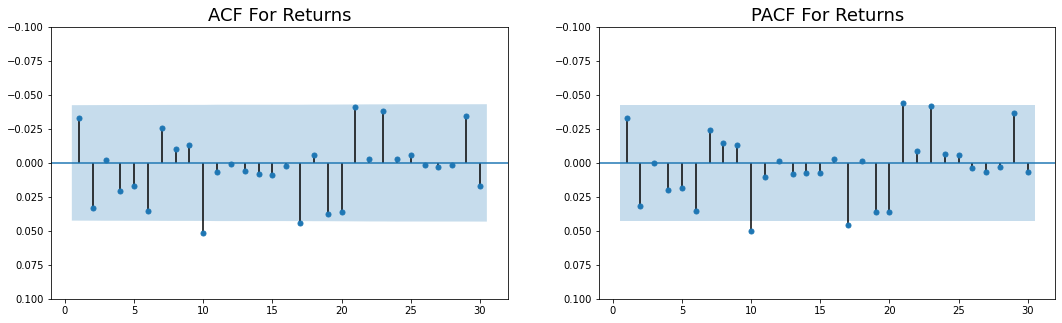

In [ ]:
# Fixing plot size
plt.rcParams["figure.figsize"] = 18, 5

# Defining Subplots
fig, axes = plt.subplots(1, 2)

# Plotting ACF and PACF for Returns
sm.graphics.tsa.plot_acf(ret, zero = False, lags = 30, ax = axes[0])
sm.graphics.tsa.plot_pacf(ret, zero = False, lags = 30, ax = axes[1])

axes[0].set_ylim([0.1, -0.1])
axes[1].set_ylim([0.1, -0.1])
axes[0].set_title("ACF For Returns", size = 18)
axes[1].set_title("PACF For Returns", size = 18)

# Display the Plot
plt.show()

In [ ]:
test_size = len(ret.ret['01-01-2021':])
train, test = ret[:-test_size], ret[-test_size:]


test_size_per =round(test_size*100/len(ret),1)
print(f'Test size(%): {test_size_per}% \nTrain size(%): {100-test_size_per}%')

Test size(%): 14.2% 
Train size(%): 85.8%


In [ ]:
#####Test of ARCH effect
arch_effect = het_arch(ret)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
zip_arch = dict(zip(labels, arch_effect))
ret_arch = pd.DataFrame(zip_arch, index=['value']).transpose()
ret_arch

,value
LM Statistic,5.577535e+01
LM-Test p-value,2.261709e-08
F-Statistic,5.698576e+00
F-Test p-value,1.776208e-08


In [ ]:
## Auto Arima Model

model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=8, max_q=8, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=2, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6609.984, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6608.879, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6608.816, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6607.947, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6614.165, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6613.362, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6613.285, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6612.485, Time=0.65 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.226 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1826
Model:                        SARIMAX   Log Likelihood                3309.082
Date:                Mon, 10 Jan 2022   AIC                          -6614.165
Time:                       

In [ ]:
### optimal ARMA model
from statsmodels.tsa.arima.model import ARIMA
p= 1
d= 0
q= 1
mod = ARIMA(train, order=(p, d, q))
ar_ret = mod.fit()
print(ar_ret.summary())


                               SARIMAX Results                                
Dep. Variable:                    ret   No. Observations:                 1826
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3310.329
Date:                Mon, 10 Jan 2022   AIC                          -6612.657
Time:                        01:35:13   BIC                          -6590.618
Sample:                    01-02-2016   HQIC                         -6604.527
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.466      0.014       0.000       0.004
ar.L1         -0.4977      0.386     -1.290      0.197      -1.254       0.258
ma.L1          0.4659      0.391      1.193      0.2

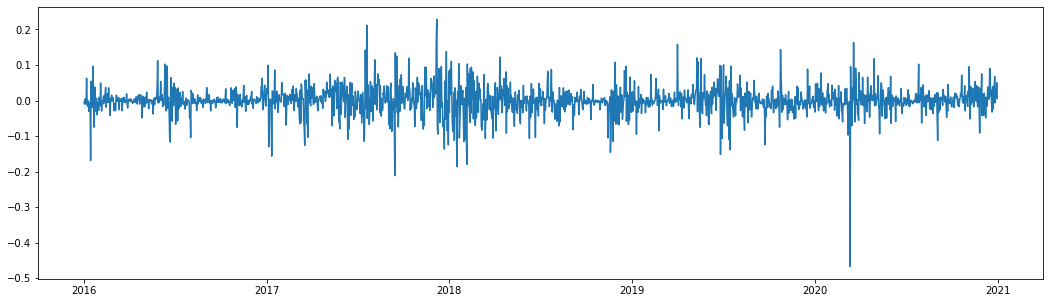

In [ ]:
plt.plot(ar_ret.resid)

The p-value of Ljung Box above is greater that 5% significant level. This implies that the residuals are independent and that the model meets the assumption of autocorrelation.
Here, we see that the conditional mean is stationary but the p-value of the heteroscedasticity test is significant indicating that the conditional volatility is non stationary

In [ ]:
#####Test of ARCH effect
arch_effect = het_arch(ar_ret.resid)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
zip_arch = dict(zip(labels, arch_effect))
ret_arch = pd.DataFrame(zip_arch, index=['value']).transpose()
ret_arch

,value
LM Statistic,43.699516
LM-Test p-value,0.000004
F-Statistic,4.450579
F-Test p-value,0.000003


Next, We Run the Garch Models: We compare the Garch(1,1) 

In [ ]:
from arch.univariate import EGARCH

### GARCH NORMAL

In [ ]:
#GARCH(1,1)
Gmodel1 = arch_model(ret, vol = "GARCH", p=1, q=1)
Gmodel1_fit = Gmodel1.fit(update_freq=5)
print(Gmodel1_fit.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3995.926823829234
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3995.93
Distribution:                  Normal   AIC:                          -7983.85
Method:            Maximum Likelihood   BIC:                          -7961.20
                                        No. Observations:                 2129
Date:                Mon, Jan 10 2022   Df Residuals:                     2128
Time:                        04:15:31   Df Model:                            1
                                 Mean Model                                 
   

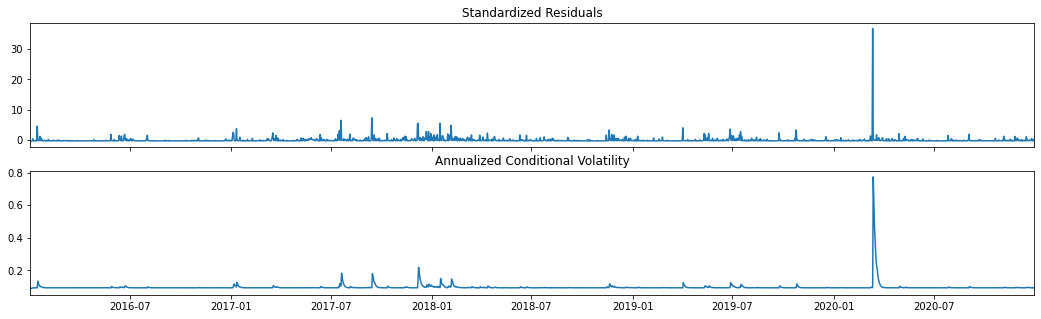

In [ ]:
Garch_fig = Gmodel1_fit.plot(annualize="D")

In [ ]:
#EGARCH(1,1)
Emodel1 = arch_model(ret, vol = 'EGARCH', p=1,o=1, q=1,)
Emodel1_fit = Emodel1.fit(update_freq=4)
print(Emodel1_fit.summary())

Iteration:      4,   Func. Count:     43,   Neg. LLF: -4009.5121691422964
Iteration:      8,   Func. Count:     78,   Neg. LLF: -4017.104605257186
Iteration:     12,   Func. Count:    106,   Neg. LLF: -4018.49591560431
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4018.4959960185447
            Iterations: 14
            Function evaluations: 120
            Gradient evaluations: 14
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                4018.50
Distribution:                  Normal   AIC:                          -8026.99
Method:            Maximum Likelihood   BIC:                          -7998.67
                                        No. Observations:                 2129
Date:          

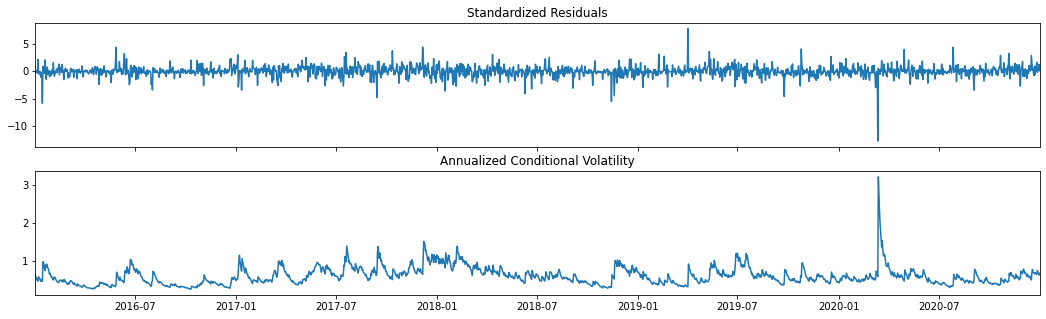

In [ ]:
EGarch_fig = Emodel1_fit.plot(annualize="D")

### GARCH AND EGARCH with Student T Distribution

In [ ]:
#GARCH(1,1)-student t
Gmodel2 = arch_model(ret, p=1, q=1, dist ='StudentsT')
Gmodel2_fit =Gmodel2.fit(update_freq=4)
print(Gmodel2_fit.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4293.275394626084
            Iterations: 6
            Function evaluations: 23
            Gradient evaluations: 2
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                4293.28
Distribution:      Standardized Student's t   AIC:                          -8576.55
Method:                  Maximum Likelihood   BIC:                          -8548.23
                                              No. Observations:                 2129
Date:                      Mon, Jan 10 2022   Df Residuals:                     2128
Time:                              04:18:32   Df Model:                            1
                          

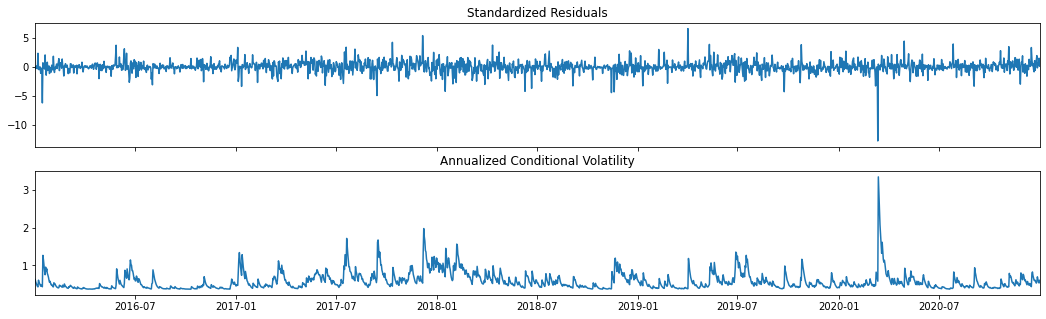

In [ ]:
Garch_fig2 = Gmodel2_fit.plot(annualize="D")

In [ ]:
#EGARCH(1,1)-student t
Emodel2 = arch_model(ret, vol = 'EGARCH', p=1,o=1, q=1, dist = 'StudentsT',)
Emodel2_fit = Emodel2.fit(update_freq=100)
print(Emodel2_fit.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4349.041052639833
            Iterations: 27
            Function evaluations: 252
            Gradient evaluations: 27
                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                4349.04
Distribution:      Standardized Student's t   AIC:                          -8686.08
Method:                  Maximum Likelihood   BIC:                          -8652.10
                                              No. Observations:                 2129
Date:                      Mon, Jan 10 2022   Df Residuals:                     2128
Time:                              07:27:02   Df Model:                            1
                       

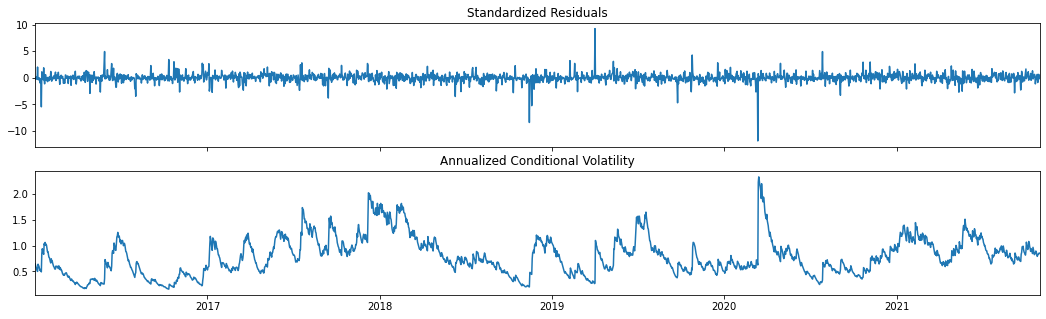

In [ ]:
EGarch_fig2 = Emodel2_fit.plot(annualize="D")

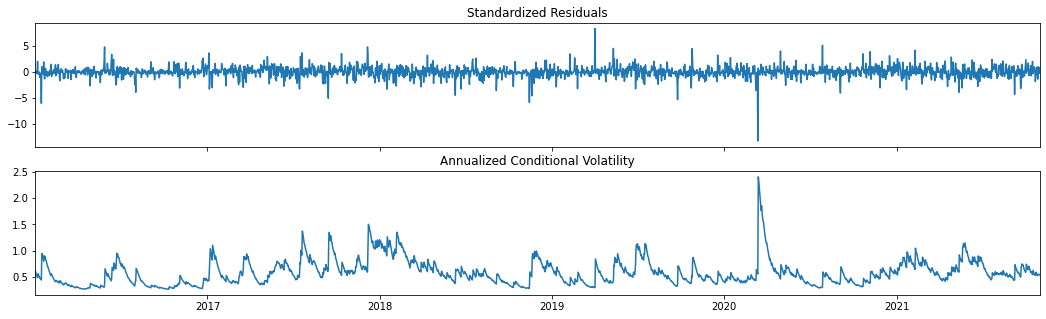

In [ ]:
Garch_fig2 = Gmodel2_fit.plot(annualize="D")

In [ ]:
# Obtain model estimated residuals and volatility
model_resid = Emodel2_fit.resid
model_std = Emodel2_fit.conditional_volatility

In [ ]:
# Calculate the standardized residuals
model_std_resid = model_resid /model_std

In [ ]:
sm.stats.acorr_ljungbox(model_std_resid**2, lags=36, return_df=True)

,lb_stat,lb_pvalue
1,0.027355,0.868635
2,0.122212,0.940724
3,0.513315,0.915957
4,0.880989,0.927272
5,5.277901,0.382914
6,5.312604,0.504389
7,5.312605,0.621873
8,5.367201,0.717704
9,5.453978,0.793076
10,5.464447,0.858076


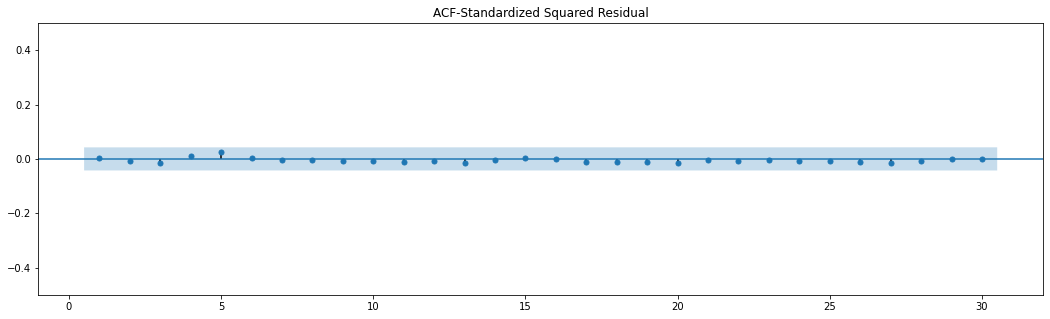

In [ ]:
plt.rcParams["figure.figsize"] = 18, 5

# Plotting ACF Standardized Residual

plot_acf(model_std_resid**2, zero = False, lags = 30)
ax = plt.gca()
ax.set_ylim([-0.5, 0.5])
plt.title('ACF-Standardized Squared Residual')
plt.show()

### Forecast for the first 10 months of 2021

In [ ]:
#Expanded Window Forecast for Normal-Garch
vol_for = []


for i in range(test_size):
    train = ret[:-(test_size-i)]
    model = arch_model(train,vol = 'EGARCH', p=1,o=1, q=1, dist = 't')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    vol_for.append(np.sqrt(pred.variance.values[-1,:][0]))
    

In [ ]:
vol_for = pd.Series(vol_for, index=ret.index[-test_size:])

vol_for.head()

Date
2021-01-01    0.065306
2021-01-02    0.062272
2021-01-03    0.075702
2021-01-04    0.073130
2021-01-05    0.070746
dtype: float64

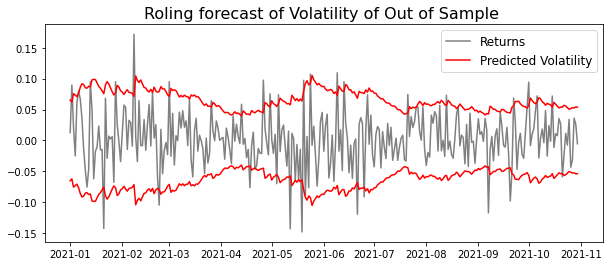

In [ ]:

plt.figure(figsize=(10,4))
true = plt.plot(test, color = 'grey')
preds = plt.plot(vol_for, color ='red')
preds2 = plt.plot(-vol_for, color ='red')
plt.title('Roling forecast of Volatility of Out of Sample ', fontsize=16)
plt.legend(['Returns', 'Predicted Volatility'], fontsize=12)

